In [1]:
"""
策略名稱:順勢交易

因好奇追漲殺跌是否是一個有效的策略而嘗試使用KD指標來判斷趨勢
那因此這是就根據KD指標來寫出一個專門追高跟殺低的策略
那這次策略是多空都做，希望不會變成多空雙巴

本次策略採用指標
KD指標（英文：Stochastic Oscillator），也稱為隨機指標，是技術分析常見的指標之一，主要用於判斷股價短期的強弱程度與可能反轉的時機。KD 指標的數值介於 0-100，一般以 50 作為分水嶺，當指標大於 50 時，表示股價處於強勢階段；反之，當股價小於 50 時，股價屬於弱勢階段。另外，當 KD 指標小於 20 時，股票往往有超賣的跡象，隨時有反轉向上的可能；反之當 KD 指標大於 80 時，股票往往有超買的跡象，隨時有反轉向下的可能。因此，許多人依此來建構交易訊號，作為買賣股票的依據。

KD 指標的計算流程如下：

RSV = ( ( 當日收盤價 – 近 N 日的最低價 ) / ( 近 N 日的最高價 – 近 N 日的最低價 ) ) * 100
K 值 = 昨日 K 值 × ( 2 / 3 ) + 當日 RSV × ( 1 / 3 )
D 值 = 昨日 D 值 × ( 2 / 3 ) + 當日 K 值 × ( 1 / 3 )
從算式來看，可以把 RSV 解讀成當日股價相較於近 N 日股價，是屬於較強勢還是弱勢。K 值，又被稱為快線，因為受到當日股價強弱的影響較大；而 D 值計算的原理如同再進行一次平滑，故對當前股價變化反應較慢。

另外，算式中的 N 值為計算指標的移動窗格，可以根據不同的投資屬性而定。設定較大的 N 值可以使 KD 值趨於平穩，並因為基於較長的基期計算 KD 值，可使指標提供的反轉訊號較為精準，適合中長期的投資人。反之，較小的 N 值會使 KD 指標較為敏感，適合短期的投資人。

KD 指標策略
本文採用 KD 指標來判斷股價反轉時機，利用以下進出場規則建立交易策略並進行回測：

K ≤ 30  做空，因其代表股價較弱、市場過冷的狀態
K ≥ 30  回補，因為代表趨是有機會從極度弱勢轉回，所以要先回補
K ≥ 85  買入，代表市場過熱，因為根據策略我們得跟著趨勢走
k ≤ 85  賣出，代表開始趨勢可能要翻轉了，根據策略我們得賣出了
"""

'\n策略名稱:順勢交易\n\n因好奇追漲殺跌是否是一個有效的策略而嘗試使用KD指標來判斷趨勢\n那因此這是就根據KD指標來寫出一個專門追高跟殺低的策略\n那這次策略是多空都做，希望不會變成多空雙巴\n\n本次策略採用指標\nKD指標（英文：Stochastic Oscillator），也稱為隨機指標，是技術分析常見的指標之一，主要用於判斷股價短期的強弱程度與可能反轉的時機。KD 指標的數值介於 0-100，一般以 50 作為分水嶺，當指標大於 50 時，表示股價處於強勢階段；反之，當股價小於 50 時，股價屬於弱勢階段。另外，當 KD 指標小於 20 時，股票往往有超賣的跡象，隨時有反轉向上的可能；反之當 KD 指標大於 80 時，股票往往有超買的跡象，隨時有反轉向下的可能。因此，許多人依此來建構交易訊號，作為買賣股票的依據。\n\nKD 指標的計算流程如下：\n\nRSV = ( ( 當日收盤價 – 近 N 日的最低價 ) / ( 近 N 日的最高價 – 近 N 日的最低價 ) ) * 100\nK 值 = 昨日 K 值 × ( 2 / 3 ) + 當日 RSV × ( 1 / 3 )\nD 值 = 昨日 D 值 × ( 2 / 3 ) + 當日 K 值 × ( 1 / 3 )\n從算式來看，可以把 RSV 解讀成當日股價相較於近 N 日股價，是屬於較強勢還是弱勢。K 值，又被稱為快線，因為受到當日股價強弱的影響較大；而 D 值計算的原理如同再進行一次平滑，故對當前股價變化反應較慢。\n\n另外，算式中的 N 值為計算指標的移動窗格，可以根據不同的投資屬性而定。設定較大的 N 值可以使 KD 值趨於平穩，並因為基於較長的基期計算 KD 值，可使指標提供的反轉訊號較為精準，適合中長期的投資人。反之，較小的 N 值會使 KD 指標較為敏感，適合短期的投資人。\n\nKD 指標策略\n本文採用 KD 指標來判斷股價反轉時機，利用以下進出場規則建立交易策略並進行回測：\n\nK ≤ 20  做空，因其代表股價較弱、市場過冷的狀態\nK ≥ 30  回補，因為代表趨是有機會從極度弱勢轉回，所以要先回補\nK ≥ 85  買入，代表市場過熱，因為根據策略我們得跟著趨勢走\nk ≤ 75  賣出，代表開始趨勢可能要翻轉了，根據策略我們得賣出了\n'

In [102]:
import os
import pandas as pd
import numpy as np
import tejapi
import matplotlib.pyplot as plt

In [103]:
os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'EOCprUG3A6FZFta9iUPXWYu8JQgjmY'
os.environ['mdate'] = '20210101 20240526'
os.environ['ticker'] = '0050'

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 18/1000 (1.8%)
Currently used TEJ API key data quota 8140/10000000 (0.08%)


[2024-05-28 15:40:08.489824] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-05-28 15:40:11.675058] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [104]:
from zipline.api import (set_slippage, 
                         set_commission, 
                         set_benchmark, 
                         attach_pipeline, 
                         symbol, 
                         pipeline_output,
                         record, 
                         order,
                         order_target
                        )
from zipline.pipeline.filters import StaticSids
from zipline.finance import slippage, commission
from zipline import run_algorithm
from zipline.pipeline import CustomFactor, Pipeline
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.factors import ExponentialWeightedMovingAverage
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order, order_target, symbol, pipeline_output, record
from zipline.finance import commission, slippage
from zipline.data import bundles
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.factors import BollingerBands
from zipline.pipeline.data import EquityPricing
from zipline.sources.TEJ_Api_Data import get_universe
from zipline.pipeline.data import TWEquityPricing
from zipline.TQresearch.tej_pipeline import run_pipeline   

from zipline.api import *
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage

from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                            get_Benchmark_Return)

import pyfolio as pf

plt.rcParams['axes.unicode_minus'] = False


In [711]:
from zipline.api import order, record, symbol, set_slippage, set_commission, attach_pipeline, pipeline_output
from zipline.pipeline import Pipeline
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.factors import CustomFactor, ExponentialWeightedMovingAverage, BollingerBands
from zipline.finance import slippage, commission
import numpy as np

# 自定义因子: N天内最高价
class NdaysMaxHigh(CustomFactor):
    inputs = [EquityPricing.high]
    window_length = 5
    def compute(self, today, assets, out, highs):
        out[:] = np.nanmax(highs[:-1], axis=0)

# 自定义因子: N天内最低价
class NdaysMinLow(CustomFactor):
    inputs = [EquityPricing.low]
    window_length = 5
    def compute(self, today, assets, out, lows):
        out[:] = np.nanmin(lows[:-1], axis=0)

# 自定义KDJ
class FastStochasticOscillator(CustomFactor):
    inputs = [EquityPricing.close, EquityPricing.low, EquityPricing.high]
    window_length = 10

    def compute(self, today, assets, out, closes, lows, highs):
        lowest_lows = np.nanmin(lows, axis=0)
        highest_highs = np.nanmax(highs, axis=0)
        out[:] = 100 * (closes[-1] - lowest_lows) / (highest_highs - lowest_lows)


In [712]:

# 创建Pipeline
def make_pipeline():
    ema = ExponentialWeightedMovingAverage(
        inputs=[EquityPricing.close],
        window_length=7,
        decay_rate=1/7
    )
    high = NdaysMaxHigh()
    low = NdaysMinLow()
    close = EquityPricing.close.latest
    bollinger = BollingerBands(
        inputs=[EquityPricing.close],
        window_length=20,
        k=2
    )
    fast_stochastic = FastStochasticOscillator()

    return Pipeline(
        columns={
            'ema': ema,
            'highesthigh': high,
            'lowestlow': low,
            'latest': close,
            'upper': bollinger.upper,
            'middle': bollinger.middle,
            'lower': bollinger.lower,
            'curr_price': close,
            'FastStochasticOscillator': fast_stochastic,
        }
    )

In [713]:


# 初始化函数
def initialize(context):
    context.last_buy_price = 0
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost=0.00285))
    set_benchmark(symbol('0050'))
    attach_pipeline(make_pipeline(), 'mystrategy')
    context.last_signal_price = 0


In [714]:
from zipline.finance.slippage import VolumeShareSlippage

# 创建一个默认的 VolumeShareSlippage 实例
default_slippage = VolumeShareSlippage()

# 打印默认参数
print("Volume limit:", default_slippage.volume_limit)
print("Price impact:", default_slippage.price_impact)


Volume limit: 0.025
Price impact: 0.1


In [715]:

# 处理交易逻辑
def handle_data(context, data):
    pipe = pipeline_output('mystrategy')

    for i in pipe.index:
        ema = pipe.loc[i, 'ema']
        highesthigh = pipe.loc[i, 'highesthigh']
        lowestlow = pipe.loc[i, 'lowestlow']
        close = pipe.loc[i, 'latest']
        bias = close - ema
        residual_position = context.portfolio.positions[i].amount
        
        # 布林通道参数
        upper = pipe.loc[i, 'upper']
        middle = pipe.loc[i, 'middle']
        lower = pipe.loc[i, 'lower']
        curr_price = pipe.loc[i, 'curr_price']
        cash_position = context.portfolio.cash
        stock_position = context.portfolio.positions[i].amount
       
        # KD整合的条件
        short_kd = pipe.loc[i, 'FastStochasticOscillator']
        
        # 整合的条件
        hadbuy=0
        hadshort=0
        condition1 = (short_kd > 85) 
        condition2 = (short_kd <= 85)
        condition3 = (short_kd < 30) 
        condition4 = (short_kd >= 30) 
        buy, sell, short_sell, cover = False, False, False, False

        # 记录条件
        record(
            con1=condition1,
            con2=condition2,
            con3=condition3,
            con4=condition4,
            price=close,
            ema=ema,
            bias=bias,
            highesthigh=highesthigh,
            lowestlow=lowestlow,
            price2=curr_price,
            upper=upper,
            lower=lower,
            buy=buy,
            sell=sell,
            short_sell=short_sell,
            cover=cover
        )
        
        # Long position logic
        if stock_position == 0:
            if condition1 and cash_position > curr_price * 3000:
                order(i, 3000)
                context.last_signal_price = curr_price
                buy = True
                record(buy=buy)
        elif stock_position > 0:
            if condition1 and curr_price and cash_position >= curr_price * 3000:
                order(i, 3000)
                context.last_signal_price = curr_price
                buy = True
                record(buy=buy)
            elif condition2:
                order_target(i, 0)
                context.last_signal_price = 0
                sell = True
                record(sell=sell)
        
        # Short position logic
        if stock_position == 0:
            if condition3 and cash_position > curr_price * 3000:
                order(i, -3000)
                context.last_signal_price = curr_price
                short_sell = True
                record(short_sell=short_sell)
        elif stock_position < 0:
            if condition3 and cash_position >= curr_price * 3000:
                order(i, -3000)
                context.last_signal_price = curr_price
                short_sell = True
                record(short_sell=short_sell)
            elif condition4:
                order_target(i, 0)
                context.last_signal_price = 0
                cover = True
                record(cover=cover)



In [716]:
import matplotlib.pyplot as plt

def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel("Portfolio value (NTD)")
    
    ax2 = fig.add_subplot(212)
    ax2.set_ylabel("Price (NTD)")
    perf.price.plot(ax=ax2)
    
    # 繪製買入訊號
    ax2.plot(
        perf.index[perf.con2],
        perf.loc[perf.con2, 'price'],
        '^',
        markersize=5,
        color='red',
        label='Buy Signal'
    )
    
    # 繪製賣出訊號
    ax2.plot(
        perf.index[perf.con1],
        perf.loc[perf.con1, 'price'],
        'v',
        markersize=5,
        color='green',
        label='Sell Signal'
    )
    
    # 繪製做空訊號
    ax2.plot(
        perf.index[perf.short_sell],
        perf.loc[perf.short_sell, 'price'],
        'o',
        markersize=5,
        color='blue',
        label='Short Sell Signal'
    )
    
    # 繪製做空回補訊號
    ax2.plot(
        perf.index[perf.cover],
        perf.loc[perf.cover, 'price'],
        'x',
        markersize=10,
        color='purple',
        label='Cover Signal'
    )
    
    plt.legend(loc=0)
    plt.gcf().set_size_inches(18, 8)
    plt.show()


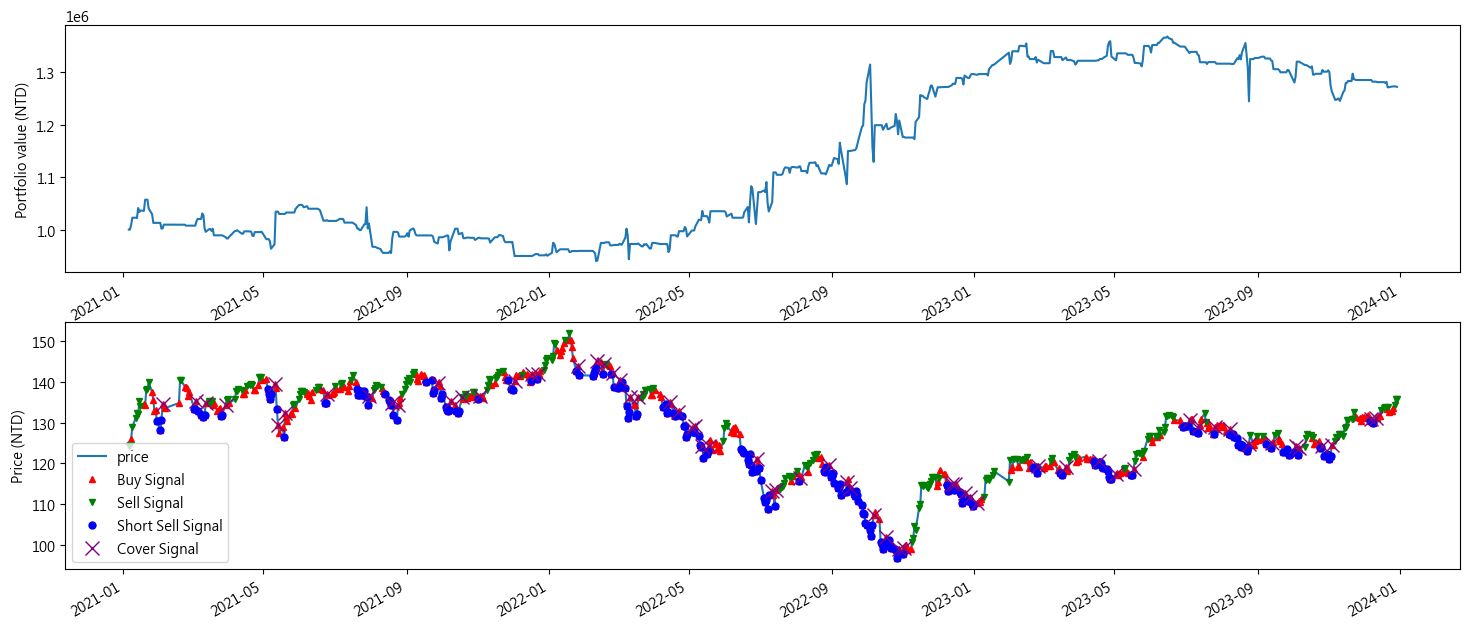

In [717]:
from zipline import run_algorithm


results = run_algorithm(start = pd.Timestamp('20210105', tz='UTC'),
                       end = pd.Timestamp('20231229', tz='UTC'),
                       initialize=initialize,
                       bundle='tquant',
                    
                       analyze=analyze,
                       capital_base=1e6,
                       handle_data = handle_data
                      )

In [718]:
results # 績效與交易明細

,period_open,period_close,treasury_return,pnl,ending_exposure,net_leverage,positions,long_exposure,ending_cash,benchmark_return,...,excess_return,benchmark_volatility,trading_days,sharpe,alpha,beta,algorithm_period_return,max_leverage,period_label,max_drawdown
2021-01-05 13:30:00+08:00,2021-01-05 09:01:00+08:00,2021-01-05 13:30:00+08:00,0.0,0.000000,0.0,0.000000,[],0.0,1.000000e+06,0.002005,...,-0.002005,NaN,1,NaN,NaN,NaN,0.000000,0.000000,2021-01,0.000000
2021-01-06 13:30:00+08:00,2021-01-06 09:01:00+08:00,2021-01-06 13:30:00+08:00,0.0,-8.552884,377850.0,0.377853,"[{'sid': Equity(0 [0050]), 'amount': 3000, 'co...",377850.0,6.221414e+05,0.010838,...,-0.012873,0.099148,2,-11.224972,0.000489,-0.000968,-0.000009,0.377853,2021-01,-0.000009
2021-01-07 13:30:00+08:00,2021-01-07 09:01:00+08:00,2021-01-07 13:30:00+08:00,0.0,8841.442611,773400.0,0.766628,"[{'sid': Equity(0 [0050]), 'amount': 6000, 'co...",773400.0,2.354329e+05,0.023423,...,-0.027756,0.170867,3,9.151856,-0.438056,0.432538,0.008833,0.766628,2021-01,-0.000009
2021-01-08 13:30:00+08:00,2021-01-08 09:01:00+08:00,2021-01-08 13:30:00+08:00,0.0,13782.883974,0.0,0.000000,[],0.0,1.022616e+06,0.017837,...,-0.032463,0.146784,4,13.147627,-0.410963,0.570898,0.022616,0.766628,2021-01,-0.000009
2021-01-11 13:30:00+08:00,2021-01-11 09:01:00+08:00,2021-01-11 13:30:00+08:00,0.0,-8.553245,396900.0,0.388126,"[{'sid': Equity(0 [0050]), 'amount': 3000, 'co...",396900.0,6.257072e+05,0.008392,...,-0.041326,0.132240,5,11.160084,-0.547061,0.610867,0.022607,0.766628,2021-01,-0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,0.0,1641.444899,0.0,0.000000,[],0.0,1.273398e+06,0.004137,...,0.088953,0.184545,724,0.578116,0.125917,-0.263100,0.273398,3.729855,2023-12,-0.141335
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,0.0,0.000000,0.0,0.000000,[],0.0,1.273398e+06,0.005618,...,0.082299,0.184444,725,0.577718,0.126306,-0.263046,0.273398,3.729855,2023-12,-0.141335
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,0.0,0.000000,0.0,0.000000,[],0.0,1.273398e+06,0.011173,...,0.068990,0.184428,726,0.577320,0.127246,-0.262772,0.273398,3.729855,2023-12,-0.141335
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,0.0,-8.551555,407250.0,0.319816,"[{'sid': Equity(0 [0050]), 'amount': 3000, 'co...",407250.0,8.661395e+05,0.000000,...,0.068982,0.184301,727,0.576909,0.127057,-0.262771,0.273389,3.729855,2023-12,-0.141335


In [719]:
import pyfolio as pf 
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [720]:
returns

2021-01-05 00:00:00+00:00    0.000000
2021-01-06 00:00:00+00:00   -0.000009
2021-01-07 00:00:00+00:00    0.008842
2021-01-08 00:00:00+00:00    0.013662
2021-01-11 00:00:00+00:00   -0.000008
                               ...   
2023-12-25 00:00:00+00:00    0.001291
2023-12-26 00:00:00+00:00    0.000000
2023-12-27 00:00:00+00:00    0.000000
2023-12-28 00:00:00+00:00   -0.000007
2023-12-29 00:00:00+00:00   -0.000713
Name: returns, Length: 728, dtype: float64

In [721]:
positions

sid,Equity(0 [0050]),cash
index,,
2021-01-06 00:00:00+00:00,377850.0,622141.447116
2021-01-07 00:00:00+00:00,773400.0,235432.889727
2021-01-11 00:00:00+00:00,396900.0,625707.220456
2021-01-12 00:00:00+00:00,792600.0,229398.667625
2021-01-13 00:00:00+00:00,811800.0,229398.667625
...,...,...
2023-12-19 00:00:00+00:00,800400.0,479649.634081
2023-12-20 00:00:00+00:00,1203750.0,78391.076632
2023-12-22 00:00:00+00:00,398850.0,872906.561589


In [722]:
transactions

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2021-01-06 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),125.950001,c7343686810f499fb84a32d942ef1c03,3000,None,2021-01-06 13:30:00+08:00,-3.778500e+05
2021-01-07 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),128.900002,a571be93ff58493eb81c9ae4280670ab,3000,None,2021-01-07 13:30:00+08:00,-3.867000e+05
2021-01-08 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),131.199997,20a570408541460fab8686be68dd1bc5,-6000,None,2021-01-08 13:30:00+08:00,7.872000e+05
2021-01-11 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),132.300001,6fa3bf12cfc647d59e00a19798ea9ce3,3000,None,2021-01-11 13:30:00+08:00,-3.969000e+05
2021-01-12 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),132.100001,af790dbfa6464f26b085398ce152da7f,3000,None,2021-01-12 13:30:00+08:00,-3.963000e+05
...,...,...,...,...,...,...,...,...
2023-12-21 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),132.599966,5006026de8864ff28554b25a6c7aab72,-9000,None,2023-12-21 13:30:00+08:00,1.193400e+06
2023-12-22 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),132.950003,b270dba588d543628cd425b4a29043da,3000,None,2023-12-22 13:30:00+08:00,-3.988500e+05
2023-12-25 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),133.499998,78c238ad48fb4f33a382145f3a458c76,-3000,None,2023-12-25 13:30:00+08:00,4.005000e+05
2023-12-28 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),135.750001,9402b42d3998421cb393e5d434ef8a4b,3000,None,2023-12-28 13:30:00+08:00,-4.072500e+05


In [723]:
benchmark_rets = results['benchmark_return'] 
from pyfolio.utils import extract_rets_pos_txn_from_zipline
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

In [724]:
returns.head()

2021-01-05 00:00:00+00:00    0.000000
2021-01-06 00:00:00+00:00   -0.000009
2021-01-07 00:00:00+00:00    0.008842
2021-01-08 00:00:00+00:00    0.013662
2021-01-11 00:00:00+00:00   -0.000008
Name: returns, dtype: float64

In [725]:
positions.head()

sid,Equity(0 [0050]),cash
index,,
2021-01-06 00:00:00+00:00,377850.0,622141.447116
2021-01-07 00:00:00+00:00,773400.0,235432.889727
2021-01-11 00:00:00+00:00,396900.0,625707.220456
2021-01-12 00:00:00+00:00,792600.0,229398.667625
2021-01-13 00:00:00+00:00,811800.0,229398.667625


In [726]:
transactions.head()

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2021-01-06 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),125.950001,c7343686810f499fb84a32d942ef1c03,3000,None,2021-01-06 13:30:00+08:00,-377850.002884
2021-01-07 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),128.900002,a571be93ff58493eb81c9ae4280670ab,3000,None,2021-01-07 13:30:00+08:00,-386700.007389
2021-01-08 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),131.199997,20a570408541460fab8686be68dd1bc5,-6000,None,2021-01-08 13:30:00+08:00,787199.983974
2021-01-11 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),132.300001,6fa3bf12cfc647d59e00a19798ea9ce3,3000,None,2021-01-11 13:30:00+08:00,-396900.003245
2021-01-12 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),132.100001,af790dbfa6464f26b085398ce152da7f,3000,None,2021-01-12 13:30:00+08:00,-396300.002832


In [727]:
import pyfolio as pf 
perf_stats = pf.plotting.show_perf_stats(
        returns,
        benchmark_rets,
        positions=positions,
        transactions=transactions)

Start date,2021-01-05
End date,2023-12-29
Total months,34
,Backtest
Annual return,8.699%
Cumulative returns,27.248%
Annual volatility,17.018%
Sharpe ratio,0.58
Calmar ratio,0.62
Stability,0.77
Max drawdown,-14.134%


<Axes: ylabel='Cumulative returns'>

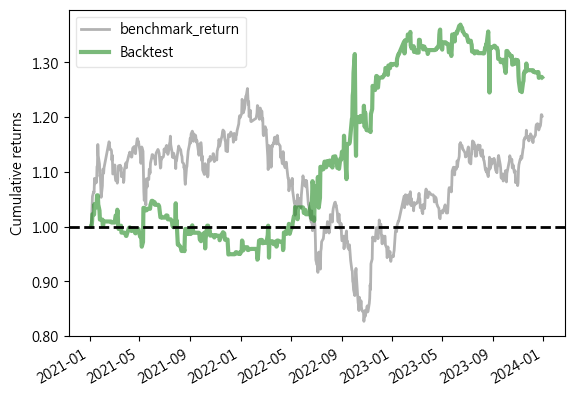

In [728]:
pf.plotting.plot_rolling_returns(returns, factor_returns=benchmark_rets)